In [1]:
import torch as tc 
from torch import nn, optim 
from torch.utils.data import DataLoader, TensorDataset, random_split 

from torchvision import transforms as T 
from torchvision import datasets

from torchmetrics import Accuracy 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import cv2

In [2]:
y = pd.read_csv('/home/ahmadreza/AI/git/rep8/dataset/archive (1)/labels_trainval.csv')

In [3]:
y.shape

(165105, 6)

In [4]:
y.xmax.max()

479

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(y.drop('class_id', axis=1), y['class_id'], train_size = 0.8, random_state = 42)

In [6]:
xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape

((132084, 5), (33021, 5), (132084,), (33021,))

In [7]:
cv2.imread(f'/home/ahmadreza/AI/git/rep8/dataset/archive (1)/images/{y.frame[0]}')

array([[[161, 136, 120],
        [155, 130, 114],
        [151, 125, 108],
        ...,
        [ 14,  18,  19],
        [ 32,  36,  37],
        [ 46,  52,  51]],

       [[164, 138, 121],
        [161, 135, 118],
        [158, 132, 115],
        ...,
        [ 15,  18,  22],
        [ 19,  24,  25],
        [ 16,  22,  21]],

       [[164, 137, 117],
        [164, 137, 117],
        [164, 137, 117],
        ...,
        [ 19,  22,  26],
        [ 17,  22,  23],
        [ 10,  15,  16]],

       ...,

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 16,  16,  16],
        ...,
        [ 16,  18,  19],
        [ 16,  18,  19],
        [ 17,  19,  20]],

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 15,  15,  15],
        ...,
        [ 16,  18,  19],
        [ 16,  18,  19],
        [ 17,  19,  20]],

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 15,  15,  15],
        ...,
        [ 16,  18,  19],
        [ 16,  18,  19],
        [ 17,  19,  20]]

In [8]:
class CNNModel(nn.Module):

    def __init__(self, num_filters, kernel_size, num_out_reg, num_classes):
        super().__init__()

        self.conv1 = nn.LazyConv2d(num_filters[0], kernel_size[0], stride = 1, padding = 1, bias = True)
        self.bn1 = nn.BatchNorm2d(num_filters[0])

        self.conv2 = nn.LazyConv2d(num_filters[1], kernel_size[1], stride = 1, padding = 1, bias = True)
        self.bn2 = nn.BatchNorm2d(num_filters[1])

        self.conv3 = nn.LazyConv2d(num_filters[1], kernel_size[1], stride = 1, padding = 1, bias = True)
        self.bn3 = nn.BatchNorm2d(num_filters[1])

        self.mpool = nn.MaxPool2d(2, 2)
        self.apool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.LazyLinear(num_classes)
        self.fcv = nn.LazyLinear(num_out_reg)
        self.seq = nn.Sequential(nn.LazyLinear(4), nn.LeakyReLU(), nn.LazyLinear(4), nn.LazyLinear(4), nn.ReLU(), nn.LazyLinear(num_out_reg))

    def forward(self, cnn_data):

        y = self.bn1(self.conv1(cnn_data)).relu()
        y = self.mpool(y)
        y = self.bn2(self.conv2(y)).relu()

        y = self.apool(y)

        y = y.flatten(1)

        y_class = self.fc(y)

        y = self.bn3(self.conv3(cnn_data))

        y = y.flatten(1)

        y_reg = self.seq(y)

        return y_reg, y_class

In [9]:
device = 'cpu' if tc.cuda.is_available() else 'cpu'

In [10]:
def num_choose(i, data_loader):
    xn, yn = 0, 0
    o = 0
    for x, y in data_loader:
        if o==i:
            xn, yn = x, y
            
        o += 1
    
    return xn, yn

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def train_one_epoch(model, loss_func_reg, loss_func_class, optimizer, epoch):
    model.train()

    train_loss_reg = AverageMeter()
    train_loss_class = AverageMeter()
    train_acc_class = Accuracy(task = 'multiclass', num_classes=5).to(device)

    print(f'epoch={epoch}')
    print()
    print('TRAIN::::')

    for i in range(0, 5):

        x_part = xtrain.iloc[i * 100: i * 100 + 100]
        y_part = ytrain.iloc[i * 100: i * 100 + 100] - 1

        for l in range(0, x_part.shape[0]):
            pd.options.mode.chained_assignment = None
            x_part.frame.iloc[l] = tc.FloatTensor(cv2.imread(f'/home/ahmadreza/AI/git/rep8/dataset/archive (1)/images/{x_part.frame.iloc[l]}')).permute(2, 0, 1)/255
        
        cnn_train = x_part.frame.iloc[0].unsqueeze(0)
        
        for l in x_part.frame.iloc[1:]:
            x = l.unsqueeze(0)
            cnn_train = tc.cat([cnn_train, x])
        
        y_part = tc.LongTensor(np.array(y_part))
        x_part = tc.FloatTensor(np.array(x_part.drop(['frame'], axis = 1)))/479  

        cnn_dataset = TensorDataset(cnn_train, y_part)
        reg_dataset = TensorDataset(x_part, y_part)

        cnn_train_loader = DataLoader(cnn_dataset, batch_size=32, shuffle = False)
        reg_train_loader = DataLoader(reg_dataset, batch_size=32, shuffle = False)


        with tqdm(cnn_train_loader, unit = 'batch') as tepoch:
            
            j = 0

            for xc, yc in tepoch:
                if epoch is not None:
                    tepoch.set_description(f'iteration={i}')
                xn, yn = num_choose(j, reg_train_loader)
                j +=1

                xn = xn.to(device)
                xc = xc.to(device)

                yn = yn.to(device)

                y_reg, y_class = model(xc)
                
                loss_reg = loss_func_reg(y_reg, xn)
                loss_class = loss_func_class(y_class, yn)

                loss_reg.backward(retain_graph=True)
                loss_class.backward()

                optimizer.step()
                optimizer.zero_grad()

                train_loss_reg.update(loss_reg.item())
                train_loss_class.update(loss_class.item())

                train_acc_class(y_class, yn)

                reg_loss = train_loss_reg.avg
                class_loss = train_loss_class.avg

                tepoch.set_postfix(loss_reg = reg_loss,
                                    loss_class = class_loss,
                                    loss = (reg_loss + class_loss))

    return model, train_loss_reg.avg, train_loss_class.avg

In [13]:
def validation(model, loss_func_reg, loss_func_class, epoch):
    model.eval()

    valid_loss_reg = AverageMeter()
    valid_loss_class = AverageMeter()
    valid_acc_class = Accuracy(task = 'multiclass', num_classes=5).to(device)

    print('VALIDATION::::')

    with tqdm(np.arange(0, 5), unit='t') as s:

        for i in s:
            s.set_description(f'iteration={i}')

            x_part = xvalid.iloc[i * 100: i * 100 + 100]
            y_part = yvalid.iloc[i * 100: i * 100 + 100] - 1

            for l in range(0, x_part.shape[0]):
                pd.options.mode.chained_assignment = None
                x_part.frame.iloc[l] = tc.FloatTensor(cv2.imread(f'/home/ahmadreza/AI/git/rep8/dataset/archive (1)/images/{x_part.frame.iloc[l]}')).permute(2, 0, 1)/255
        
            cnn_valid = x_part.frame.iloc[0].unsqueeze(0)
            for l in x_part.frame.iloc[1:]:
                x = l.unsqueeze(0)
                cnn_valid = tc.cat([cnn_valid, x])

            y_part = tc.LongTensor(np.array(y_part))
            x_part = tc.FloatTensor(np.array(x_part.drop(['frame'], axis = 1)))/479

            cnn_dataset = TensorDataset(cnn_valid, y_part)
            reg_dataset = TensorDataset(x_part, y_part)

            cnn_valid_loader = DataLoader(cnn_dataset, batch_size=32, shuffle = False)
            reg_valid_loader = DataLoader(reg_dataset, batch_size=32, shuffle = False)

            j = 0

            for xc, yc in cnn_valid_loader:
                
                xn, yn = num_choose(j, reg_valid_loader)
                j += 1

                xn = xn.to(device)
                xc = xc.to(device)

                yn = yn.to(device)

                y_reg, y_class = model(xc)

                loss_reg = loss_func_reg(y_reg, xn)
                loss_class = loss_func_class(y_class, yn)

                valid_loss_reg.update(loss_reg.item())
                valid_loss_class.update(loss_class.item())

                valid_acc_class(y_class, yn)

                reg_loss = valid_loss_reg.avg
                class_loss = valid_loss_class.avg
                total_loss = reg_loss + class_loss



    print(f'============regression loss={reg_loss}, classification loss={class_loss}, Loss(total)={total_loss}===============')
    print()


    return valid_loss_reg.avg, valid_loss_class.avg

In [127]:
model = CNNModel([8, 8], [3, 3], 4, 5).to(device)

/home/ahmadreza/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [47]:
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas = [0.9, 0.99])
loss_func_reg = nn.HuberLoss()
loss_func_class = nn.CrossEntropyLoss()

In [48]:
_, _, _ = train_one_epoch(model, loss_func_reg, loss_func_class, optimizer, 1)

epoch=1


iteration=9: 100%|██████████| 4/4 [00:02<00:00,  1.74batch/s, loss=2.28, loss_class=1.65, loss_reg=0.628]


In [26]:
model = CNNModel([8, 8], [3, 3], 4, 5).to(device)

/home/ahmadreza/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
optimizer = optim.Adam(model.parameters(), lr = 0.005, betas=[0.9, 0.99], weight_decay=1e-4)
loss_func_reg = nn.HuberLoss()
loss_func_class = nn.CrossEntropyLoss()

In [28]:
N=10

loss_train_hist_reg,loss_valid_hist_reg=[],[]
loss_train_hist_class,loss_valid_hist_class=[],[]

best_loss = tc.inf
best_model = [0]

In [29]:
for epoch in range(N):
  y = pd.read_csv('/home/ahmadreza/AI/git/rep8/dataset/archive (1)/labels_trainval.csv')
  xtrain, xvalid, ytrain, yvalid = train_test_split(y.drop('class_id', axis=1), y['class_id'], train_size = 0.8, random_state = 42)

  model, train_loss_reg, train_loss_class = train_one_epoch(model, loss_func_reg, loss_func_class, optimizer, epoch)

  y = pd.read_csv('/home/ahmadreza/AI/git/rep8/dataset/archive (1)/labels_trainval.csv')
  xtrain, xvalid, ytrain, yvalid = train_test_split(y.drop('class_id', axis=1), y['class_id'], train_size = 0.8, random_state = 42)

  valid_loss_reg, valid_loss_class = validation(model, loss_func_reg, loss_func_class, epoch)

  loss_train_hist_reg.append(train_loss_reg)
  loss_train_hist_class.append(train_loss_class)

  loss_valid_hist_reg.append(valid_loss_reg)
  loss_valid_hist_class.append(valid_loss_class)

  valid_loss_total = (valid_loss_reg + valid_loss_class)

  if valid_loss_total<best_loss:
    best_model[0] = model 
    best_loss = valid_loss_total
    print('model saved!')
    print()

epoch=0

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:01<00:00,  2.34batch/s, loss=4.73, loss_class=1.69, loss_reg=3.04]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:09<00:00,  1.86s/t]


============regression loss=0.5939095597714186, classification loss=1.5135067641735076, Loss(total)=2.107416323944926===============

model saved!

epoch=1

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:01<00:00,  2.35batch/s, loss=1.79, loss_class=1.34, loss_reg=0.449]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:10<00:00,  2.02s/t]


============regression loss=0.10483975410461426, classification loss=1.2228016555309296, Loss(total)=1.3276414096355438===============

model saved!

epoch=2

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.98batch/s, loss=1.23, loss_class=1.07, loss_reg=0.156]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:10<00:00,  2.09s/t]


============regression loss=0.09490194953978062, classification loss=0.9569273561239242, Loss(total)=1.051829305663705===============

model saved!

epoch=3

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.70batch/s, loss=1.03, loss_class=0.942, loss_reg=0.0829]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:11<00:00,  2.22s/t]


============regression loss=0.06008885484188795, classification loss=0.9148285821080208, Loss(total)=0.9749174369499087===============

model saved!

epoch=4

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.75batch/s, loss=0.949, loss_class=0.905, loss_reg=0.0441]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:10<00:00,  2.17s/t]


============regression loss=0.039173968695104124, classification loss=0.9016327947378159, Loss(total)=0.94080676343292===============

model saved!

epoch=5

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:03<00:00,  1.30batch/s, loss=1.05, loss_class=0.887, loss_reg=0.162]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:15<00:00,  3.03s/t]


============regression loss=0.03342732824385166, classification loss=0.8837169021368027, Loss(total)=0.9171442303806543===============

model saved!

epoch=6

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.36batch/s, loss=0.904, loss_class=0.878, loss_reg=0.0259]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:16<00:00,  3.25s/t]


============regression loss=0.025017741415649653, classification loss=0.8712145373225212, Loss(total)=0.8962322787381708===============

model saved!

epoch=7

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.49batch/s, loss=0.894, loss_class=0.872, loss_reg=0.022] 


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:14<00:00,  2.85s/t]


============regression loss=0.02077015694230795, classification loss=0.893988835811615, Loss(total)=0.914758992753923===============

epoch=8

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.37batch/s, loss=0.882, loss_class=0.862, loss_reg=0.0196]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:13<00:00,  2.63s/t]


============regression loss=0.01880900710821152, classification loss=0.8498630747199059, Loss(total)=0.8686720818281174===============

model saved!

epoch=9

TRAIN::::


iteration=4: 100%|██████████| 4/4 [00:02<00:00,  1.74batch/s, loss=0.875, loss_class=0.857, loss_reg=0.0181]


VALIDATION::::


iteration=4: 100%|██████████| 5/5 [00:12<00:00,  2.46s/t]

============regression loss=0.016835685004480183, classification loss=0.8450925871729851, Loss(total)=0.8619282721774653===============

model saved!



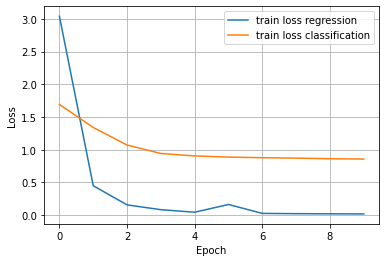

In [30]:
plt.plot(range(N), loss_train_hist_reg, label = 'train loss regression')
plt.plot(range(N), loss_train_hist_class, label = 'train loss classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.xticks(np.arange(1, N))
plt.grid()
plt.show()

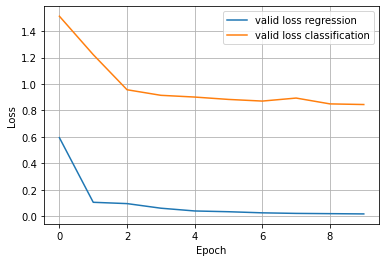

In [31]:
plt.plot(range(N), loss_valid_hist_reg, label = 'valid loss regression')
plt.plot(range(N), loss_valid_hist_class, label = 'valid loss classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.xticks(np.arange(1, N))
plt.grid()
plt.show()